In [29]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
from google.colab import drive
from itertools import product
from random import sample
from sklearn.preprocessing import normalize

In [30]:
drive.mount('/content/drive')
rootfolder = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Useful function for plot the 2D DCT dictionary

In [31]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [32]:
def OMP(s, D, L, tau):
  r = s
  omega = []
  M, N = D.shape
  x = np.zeros(N)

  while np.count_nonzero(x) < L and np.linalg.norm(r,2) > tau:
  # SWEEP STEP: look for the column of D that matches at best noisySignal
  # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    z= np.zeros(N)
    for j in range(N):
      #z[j] = r.T @ D[:,j] 
      e[j] = np.linalg.norm(r,2)**2 - (r.T @ D[:,j])**2 / (np.linalg.norm(D[:,j], ord=2)**2)

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    #x_OMP[omega] = np.linalg.inv(D[:,omega].T@D[:,omega]) @ D[:,omega].T @ s
    # without computing the inverse
    x[omega] = np.linalg.solve(D[:,omega].T@D[:,omega], D[:,omega].T @ s)

    # update the residual 
    r = s - D@x
  
  return x

Load the image and rescale it in $[0,1]$

In [33]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Extract a bunch of random patches from the image

In [34]:
# Reduced number of patches to make algorithm faster
npatch = 1000
i_index = np.zeros(npatch)
j_index = np.zeros(npatch)

# sample size=npatch random i and size=npatch random j
# then extract the patch like you usually do in the loop 
i_index = np.random.randint(low=0,high=imsz[0]-p+1,size=npatch)
j_index= np.random.randint(low=0,high=imsz[1]-p+1,size=npatch)
S = np.zeros((M, npatch))

count = 0
for i in range(npatch):
  S[:,count] = img[i_index[i]:i_index[i]+p,j_index[i]:j_index[i]+p].flatten()
  count = count + 1

Remove the mean from the patches (each column of $S$ must have zero-mean)

In [35]:
for i in range(npatch):
  S[:,i] = S[:,i] - S[:,i].mean()
  

Initialize the dictionary and the coefficient matrix

In [36]:
# number of columns of the dictionary
N = 256

# random initialization
D = np.random.random((M,N))
# initialization from the signal
#D= np.zeros((M,N))
#for i in range(N):
#  D[:,i] = S[:,i]

# normalize each column of D (zero mean and unit norm)
# UPDATE D
for i in range(N):
  D[:,i] = D[:,i] - D[:,i].mean()
D = normalize(D,axis=0,norm='l2')

# number of iteration of the KSVD
max_iter = 10

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, npatch))

Main KSVD loop


In [37]:
for iter in range(max_iter):
    time_start = time.time()
    print(f'Iteration number {iter}')

    # perform the sparse coding via OMP of all the columns of S
    for n in range(npatch):
      X[:,n] = OMP(S[:,n],D,L,0)
    
    # iterate over the columns of D
    for j in range(N):
      #find which signals uses the j-th atom in the sparse coding
      omega = np.nonzero(X[j,:])[0]

      if len(omega) == 0:
        # if the atom is never used then ignore or substitute it with a random vector
        D[:,j] = np.random.random(M)
        D[:,j] = D[:,j] - D[:,j].mean()
        D = normalize(D, axis=0, norm='l2')

      else:
        E=S
        # compute the residual matrix E, ignoring the j-th atom
        for k in range(N):
          if k != j:
            E = E - (D[:,k].reshape((M,1))) @ (X[k,:].reshape((1,npatch)))

        # restrict E to the columns indicated by omega
        Eomega = E[:,omega]

        # compute the SVD of Eomega
        U, Sigma, V = np.linalg.svd(Eomega, full_matrices=False)

        # update the dictionary
        D[:,j] = U[:,0]

        # update the coefficient matrix
        X[j, omega] = Sigma[0] * V[0,:]
    
    time_end = time.time()
    print(f'This iteration took {time_end - time_start:.0f} seconds')


Iteration number 0
This iteration took 55 seconds
Iteration number 1
This iteration took 53 seconds
Iteration number 2
This iteration took 53 seconds
Iteration number 3
This iteration took 51 seconds
Iteration number 4
This iteration took 53 seconds
Iteration number 5
This iteration took 56 seconds
Iteration number 6
This iteration took 51 seconds
Iteration number 7
This iteration took 53 seconds
Iteration number 8
This iteration took 51 seconds
Iteration number 9
This iteration took 53 seconds


Show the learned dictionary

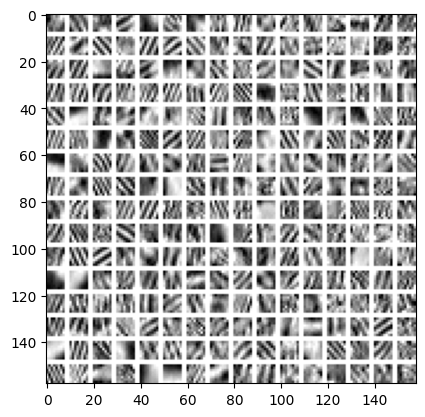

In [38]:
img_dict = get_dictionary_img(D)
plt.figure()
plt.imshow(img_dict, cmap='gray')
